# Cerberus Network

## 1.Set Environment

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install sklearn
!pip install xlrd
!pip install seaborn
!pip install pandas
!pip install torch
!pip install matplotlib
%matplotlib inline

from pathlib import Path
import shutil
import glob

import numpy as np
import pandas as pd
import random
import copy
import collections
import re
import scipy.signal as sg
from dataclasses import dataclass
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn
import seaborn as sns
from tabulate import tabulate
from IPython.display import Markdown as md
import time
from tqdm import tqdm

<Figure size 7200x4800 with 0 Axes>

## 2.Load Data and Set Targets

In [18]:
rootdir = "/content/drive/My Drive/ML_research/virus_2024/"
DEV = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

### Load Data

In [5]:
data = np.load(rootdir + "data/_real_data/past/data_7_mix_rand.npy")
target_labels = np.load(rootdir + "data/_real_data/past/7targets.npy")

print('Data Shape :', data.shape)
print('Target Labels : ', target_labels)

n_target = data.shape[0]
n_tot = data.shape[1]
n_chs = data.shape[2]
data_len = data.shape[3]

print('Number of Targets :', n_target)
print('Number of Datasets :', n_tot)
print('Number of Channels :', n_chs)
print('Data Length : ', data_len)

Data Shape : (7, 40, 9, 51)
['1:0:0' '0:1:0' '0:0:1' '1:1:0' '1:0:1' '0:1:1' '1:1:1']
['100' '010' '001' '110' '101' '011' '111']
Plain Data Shape : (7, 9, 51)


### Set Data Properties

### Set Targets

In [9]:
target_p2 = [1, 0, 0, 1, 1, 0, 1]
target_p3 = [0, 1, 0, 1, 0, 1, 1]
target_rsv = [0, 0, 1, 0, 1, 1, 1]

## 3.Split Data to Train and Test Dataset

### Data Split Function
Split data into train, validation, test

In [10]:
def split_data(val_r, test_r, data):

    virus_data = {}
    virus_data.clear

    for i in range(len(target_labels)):
        virus_data[target_labels[i]] = np.transpose(data[i])

    virus_data_train = {}
    virus_data_val = {}
    virus_data_test = {}
    virus_data_train.clear
    virus_data_val.clear
    virus_data_test.clear

    for i in range(len(virus_data.keys())):

        trans_data = np.transpose(virus_data[target_labels[i]])

        train_tot_ds, test_ds = train_test_split(trans_data, test_size=test_r, random_state=150)
        train_ds, val_ds = train_test_split(train_tot_ds, test_size=val_r, random_state=150)

        n_train = train_ds.shape[0]
        n_val = val_ds.shape[0]
        n_test = test_ds.shape[0]

        virus_data_train[target_labels[i]] = train_ds
        virus_data_val[target_labels[i]] = val_ds
        virus_data_test[target_labels[i]] = test_ds

    return n_train, n_val, n_test, virus_data, virus_data_train, virus_data_val, virus_data_test

### Data Split

In [11]:
val_r = 0.1
test_r = 0.33

n_train, n_val, n_test, virus_data, virus_data_train, virus_data_val, virus_data_test = split_data(val_r, test_r, data)

print('Total Data Shape :', virus_data[target_labels[0]].shape)
print('Train Data Shape :', virus_data_train[target_labels[0]].shape)
print('Validation Data Shape :', virus_data_val[target_labels[0]].shape)
print('Test Data Shape :',virus_data_test[target_labels[0]].shape)
print('Number of Train Set :', n_train)
print('Number of Validation Set :', n_val)
print('Number of Test Set :', n_test)

Total Data Shape : (51, 9, 40)
Train Data Shape : (23, 9, 51)
Validation Data Shape : (3, 9, 51)
Test Data Shape : (14, 9, 51)
Number of Train Set : 23
Number of Validation Set : 3
Number of Test Set : 14


## 4.Dataset

In [12]:
class virus_Dataset(Dataset):
    def __init__(self, dataset_):
        super(virus_Dataset, self).__init__()
        self.dataset_ = dataset_
        self.virus_keys = target_labels
        self.n_target = n_target

    def __len__(self):
        return len(self.virus_keys) * self.dataset_[self.virus_keys[0]].shape[0]

    def __getitem__(self, ix):
        n_data_ = self.dataset_[self.virus_keys[0]].shape[0]
        key_ix = ix // n_data_
        sample_ix = ix % n_data_

        virus_k = self.virus_keys[key_ix]
        virus_response = self.dataset_[virus_k][sample_ix,:,:]
        virus_target_p2 = target_p2[key_ix]
        virus_target_p3 = target_p3[key_ix]
        virus_target_rsv = target_rsv[key_ix]

        return virus_k, torch.FloatTensor(virus_response), torch.FloatTensor([virus_target_p2]), torch.FloatTensor([virus_target_p3]), torch.FloatTensor([virus_target_rsv])

## 5.Build Model

### Hyperparameters

In [13]:
# default hyperparameter
@dataclass
class HP:

    num_epochs: int = 500
    n_target: int = 1
    n_channel: int = 9
    kernel_size: int = 7
    stride: int = 1
    padding: int = 3

    bsz_train: int = 1
    bsz_test: int = 1
    lr: float = 1e-5
    dropout: float = 0

    decay_rate: float = 1e-5
    weight_decay: float = 1e-5
    patience: int = 5
    seed: int = 1111

### Multi-head Model

In [14]:
# model
class virus_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm((HP.n_channel, data_len))
        self.seq_cnn = nn.Sequential(
            nn.Conv1d(HP.n_channel, 16, kernel_size=HP.kernel_size, stride=HP.stride, padding=HP.padding),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=HP.kernel_size, stride=HP.stride, padding=HP.padding),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=HP.kernel_size, stride=HP.stride, padding=HP.padding),
            nn.ReLU()
        )

        self.norm2 = nn.LayerNorm((1, data_len))

        self.seq_lin = nn.Sequential(
            nn.Linear(1*data_len, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
            nn.ReLU()
        )

        self.head_p2 = nn.Linear(10, 1)
        self.head_p3 = nn.Linear(10, 1)
        self.head_rsv = nn.Linear(10, 1)

    def forward(self, x):
        bsz = x.size(0)
        x = self.norm(x)
        x = self.seq_cnn(x)
        x = self.norm2(x)
        x = x.reshape(bsz, -1)
        x = self.seq_lin(x)
        logit_p2 = self.head_p2(x)
        logit_p3 = self.head_p3(x)
        logit_rsv = self.head_rsv(x)

        return logit_p2, logit_p3, logit_rsv

### Train Function

In [19]:
def run_epoch(hp, model, data_loader, epoch, loss_func, dev, opt=None):
    if opt:
        model.train()
    else:
        model.eval()

    for batch in data_loader:
        virus_response, virus_target_p2, virus_target_p3, virus_target_rsv = [b.to(dev) for b in batch[1:]]
        with torch.enable_grad() if opt else torch.no_grad():

            logit_p2, logit_p3, logit_rsv = model(virus_response)

            virus_loss_p2 = loss_func(logit_p2, virus_target_p2.type_as(logit_p2))
            virus_loss_p3 = loss_func(logit_p3, virus_target_p3.type_as(logit_p3))
            virus_loss_rsv = loss_func(logit_rsv, virus_target_rsv.type_as(logit_rsv))

            loss_ = torch.stack([virus_loss_p2, virus_loss_p3, virus_loss_rsv], dim=0)
            virus_loss = loss_.mean()

        if opt:
            opt.zero_grad()
            virus_loss.backward()
            opt.step()

    return virus_loss

def virus_model_train(HP, loss_func):

    np.random.seed(HP.seed)
    torch.manual_seed(HP.seed)

    print("----------------------------------- Start Train ------------------------------------")
    train_start_t = time.time()
    train_dataset = virus_Dataset(virus_data_train)
    val_dataset = virus_Dataset(virus_data_val)
    train_loader = DataLoader(train_dataset, batch_size=HP.bsz_train, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=HP.bsz_test, shuffle=False)

    model = virus_model().to(DEV)
    opt = torch.optim.Adam(model.parameters(), lr=HP.lr, weight_decay=HP.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=HP.decay_rate, patience=HP.patience)

    virus_loss = float('inf')
    train_hist, val_hist, lr_hist = [], [], []
    for i in range(HP.num_epochs):

        train_loss = run_epoch(HP, model, train_loader, i, loss_func, DEV, opt)
        val_loss = run_epoch(HP, model, val_loader, i, loss_func, DEV)
        print(f"Epoch {i+1} : Train_loss({train_loss}), Validation_loss({val_loss})")

        train_hist.append(train_loss.detach().cpu().numpy())
        val_hist.append(val_loss.detach().cpu().numpy())
        lr_hist.append(opt.param_groups[0]['lr'])

        scheduler.step(val_loss)
        if virus_loss > val_loss:
           virus_loss = val_loss
           torch.save(model, rootdir + "cerberus.pt")

    train_time = time.time() - train_start_t
    print("----------------------------------- Train Resuts -----------------------------------")
    print("Train : Validation : Test = %d : %d : %d" %(n_train, n_val, n_test))
    print("Epochs : %d" %HP.num_epochs)
    print("Training Time : %d min %d sec" % (train_time // 60, train_time % 60))
    print(f"virus_model_loss={virus_loss}")

    return train_hist, val_hist, lr_hist, virus_loss, train_time

In [20]:
MSE = nn.MSELoss(reduction='mean')
train_hist, val_hist, lr_hist, virus_loss, train_time = virus_model_train(HP, loss_func=MSE)

----------------------------------- Start Train ------------------------------------
Epoch 1 : Train_loss(0.9698588848114014), Validation_loss(0.9683786034584045)
Epoch 2 : Train_loss(0.9521243572235107), Validation_loss(0.9513287544250488)
Epoch 3 : Train_loss(0.9358599781990051), Validation_loss(0.9349657893180847)
Epoch 4 : Train_loss(0.9195041060447693), Validation_loss(0.9183877110481262)
Epoch 5 : Train_loss(0.9004997611045837), Validation_loss(0.8987452387809753)
Epoch 6 : Train_loss(0.8594991564750671), Validation_loss(0.8572667241096497)
Epoch 7 : Train_loss(0.8108739256858826), Validation_loss(0.8085156083106995)
Epoch 8 : Train_loss(0.7678990364074707), Validation_loss(0.765826404094696)
Epoch 9 : Train_loss(0.7294712066650391), Validation_loss(0.7275442481040955)
Epoch 10 : Train_loss(0.6939052939414978), Validation_loss(0.6921043992042542)
Epoch 11 : Train_loss(0.6434621810913086), Validation_loss(0.6413030028343201)
Epoch 12 : Train_loss(0.5963993668556213), Validation_lo

### Evaluation Function

In [21]:
def virus_model_evaluation():

    true_p2 = []
    true_p3 = []
    true_rsv = []

    pred_p2 = []
    pred_p3 = []
    pred_rsv = []

    test_start_t = time.time()
    model = torch.load(rootdir + "cerberus.pt").to(DEV)

    model.eval()

    test_dataset = virus_Dataset(virus_data_test)
    test_loader = DataLoader(test_dataset, batch_size=HP.bsz_test, shuffle=False)
    with torch.no_grad():
          for virus_k, virus_response, virus_target_p2, virus_target_p3, virus_target_rsv in test_loader:
              logit_p2, logit_p3, logit_rsv = model(virus_response)

              true_p2.append(virus_target_p2.cpu())
              true_p3.append(virus_target_p3.cpu())
              true_rsv.append(virus_target_rsv.cpu())

              pred_p2.append(logit_p2)
              pred_p3.append(logit_p3)
              pred_rsv.append(logit_rsv)

    true_p2 = torch.cat(true_p2, dim=0)
    true_p3 = torch.cat(true_p3, dim=0)
    true_rsv = torch.cat(true_rsv, dim=0)

    pred_p2 = torch.cat(pred_p2, dim=0)
    pred_p3 = torch.cat(pred_p3, dim=0)
    pred_rsv = torch.cat(pred_rsv, dim=0)

    true_label = np.concatenate((true_p2, true_p3, true_rsv),axis=1)
    pred_label = np.concatenate((pred_p2, pred_p3, pred_rsv),axis=1)

    test_time = time.time() - test_start_t
    print("--------------------------------- Evaluation Resuts --------------------------------")
    print("Test Time : %d min %d sec" % (test_time // 60, test_time % 60))
    print("---------------------------------- Confusion Matrix --------------------------------")


    return np.array(true_p2), np.array(true_p3), np.array(true_rsv), np.array(pred_p2), np.array(pred_p3), np.array(pred_rsv), true_label, pred_label, test_time

## 6.Train & Test

In [22]:
true_p2, true_p3, true_rsv, pred_p2, pred_p3, pred_rsv, true_label, pred_label, test_time = virus_model_evaluation()

--------------------------------- Evaluation Resuts --------------------------------
Test Time : 0 min 0 sec
---------------------------------- Confusion Matrix --------------------------------


<ipython-input-21-f1e6792c59c6>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(rootdir + "cerberus.pt").to(DEV)


In [27]:
r2s = r2_score(true_label, pred_label)
print("Total R-Squared : ", r2s)
print("HPIV-2 R-Squared : ", r2_score(true_label[:,0], pred_label[:,0]))
print("HPIV-3 R-Squared : ", r2_score(true_label[:,1], pred_label[:,1]))
print("RSV R-Squared : ", r2_score(true_label[:,2], pred_label[:,2]))

print("HPIV-2 AUC : ", roc_auc_score(true_label[:, 0], pred_label[:, 0]))
print("HPIV-3 AUC : ", roc_auc_score(true_label[:, 1], pred_label[:, 1]))
print("RSV AUC : ", roc_auc_score(true_label[:, 2], pred_label[:, 2]))

Total R-Squared :  0.9958961606025696
HPIV-2 R-Squared :  0.9977532625198364
HPIV-3 R-Squared :  0.9938691854476929
RSV R-Squared :  0.9960660934448242
HPIV-2 AUC :  1.0
HPIV-3 AUC :  1.0
RSV AUC :  1.0


In [25]:
true_np = np.empty((n_target, n_test, 3))
prob_np = np.empty((n_target, n_test, 3))

for i in range(n_target):
    for j in range(n_test):

        pr_n = 14*i + j
        true_np[i][j] = true_label[pr_n]
        prob_np[i][j] = pred_label[pr_n]

p2 = prob_np[:, :, 0]
p3 = prob_np[:, :, 1]
rsv = prob_np[:, :, 2]

(98, 3)
(7, 14, 3)


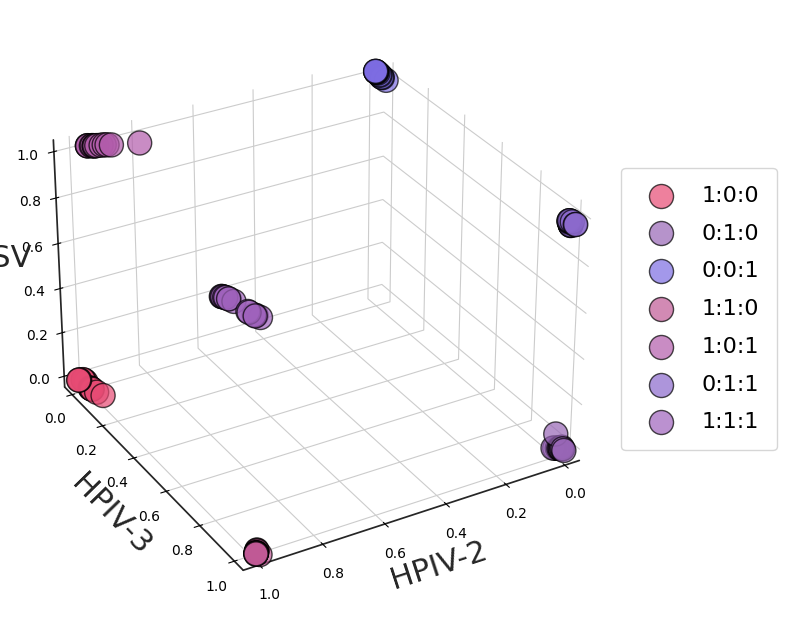

In [26]:
vi7_cm = ['#E74B74', '#9866B6', '#7D6CE2', '#c05995', '#b25cab', '#8b69cc', '#9f62bc']

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

plt.rcParams['svg.fonttype'] = 'none'
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.style.use('default')

t = np.arange(14)

for i in range(prob_np.shape[0]):

    lb_ = target_labels[ｉ]

    p11 = p2[i]
    p22 = p3[i]
    p33 = rsv[i]
    ax.scatter(p11, p22, p33, s=300, color=vi7_cm[i], edgecolors="black", alpha=0.7, label=lb_)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_zlim([-0.05, 1.05])

ax.set_xlabel("HPIV-2", labelpad = 5, fontsize=22)
ax.set_ylabel("HPIV-3", labelpad = 5, fontsize=22)
ax.set_zlabel("RSV", labelpad = 5, fontsize=22)

ax.view_init(30,60)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5), borderpad=0.8, fontsize=16, labelspacing=0.8)

plt.tight_layout()
plt.show()